<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/computationalImaging/blob/master/inverseProblems/neuralDemosaicing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Demosaicing 
## David Brady
## University of Arizona

This notebook implements a demosaicing neural network using the Kodak photo CD data set and compares the results with bilinear demosaicing. 
. 

### Load modules

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from scipy import interpolate as interp
from scipy.special import expit
from google.colab import files
import imageio
from PIL import Image
import cv2
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
tf.experimental_relax_shapes=True

### Activation functions

Activation functions are central to the operation of neural networks. Although the sigmoid activation is intuitively attractive, it's derivatives are zero over most of its range and thus it is difficult to use in gradient descent optimization. The Relu function has been found to have better training properties. These functions are plotted below

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

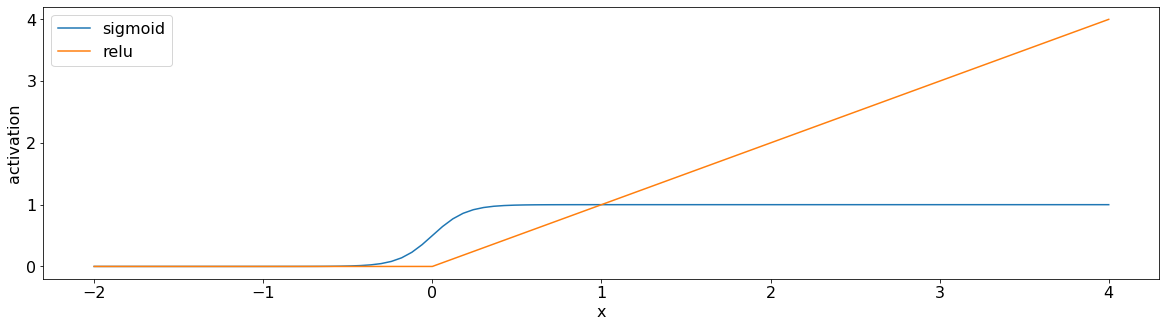

In [ ]:
#
# relu, sigmoid and softmax optimization functions
#
plt.rcParams['figure.figsize'] = [20, 5]
plt.rcParams.update({'font.size': 16})
x=np.linspace(-2,4,100)
plt.plot(x,expit(10*x),label='sigmoid')
plt.plot(x,np.maximum(x,0),label='relu')
plt.xlabel('x')
plt.ylabel('activation')
plt.legend()
plt.savefig('activation.pdf')
files.download('activation.pdf')

In [ ]:
!pip install visualkeras
import visualkeras

     |████████████████████████████████| 795 kB 5.3 MB/s 


### Bayer image example

In [ ]:
!pip install rawpy
import rawpy

     |████████████████████████████████| 1.7 MB 16.2 MB/s 


In [ ]:
!wget --no-check-certificate --content-disposition 'https://github.com/djbradyAtOpticalSciencesArizona/computationalImaging/raw/master/images/rawColor.dng'


--2021-08-24 12:39:28--  https://github.com/djbradyAtOpticalSciencesArizona/computationalImaging/raw/master/images/rawColor.dng
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/djbradyAtOpticalSciencesArizona/computationalImaging/master/images/rawColor.dng [following]
--2021-08-24 12:39:28--  https://raw.githubusercontent.com/djbradyAtOpticalSciencesArizona/computationalImaging/master/images/rawColor.dng
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24141248 (23M) [application/octet-stream]
Saving to: ‘rawColor.dng’

rawColor.dng        100%[===================>]  23.02M  --.-KB/s    in 0.1s   

In [ ]:
raw = rawpy.imread('rawColor.dng')
rawImage=raw.raw_image_visible

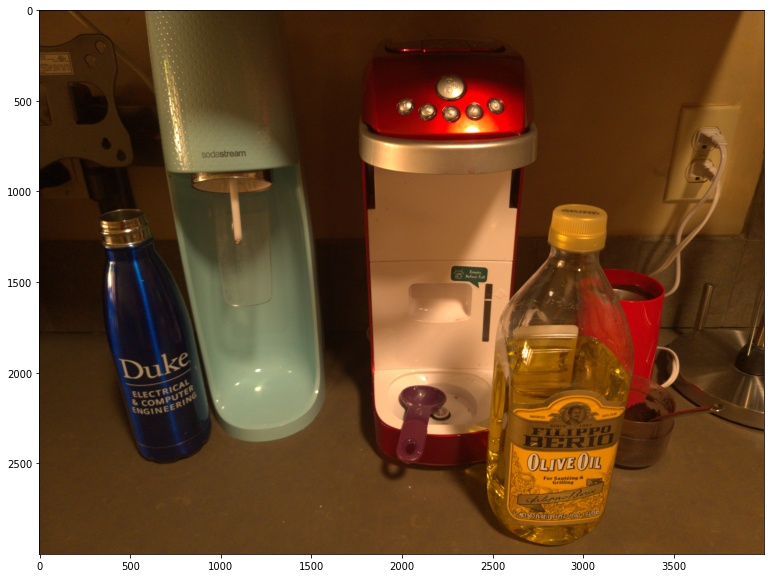

In [ ]:
plt.imshow(raw.postprocess())
#plt.axis('off')
#plt.savefig('colorExample.pdf')
#files.download('colorExample.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

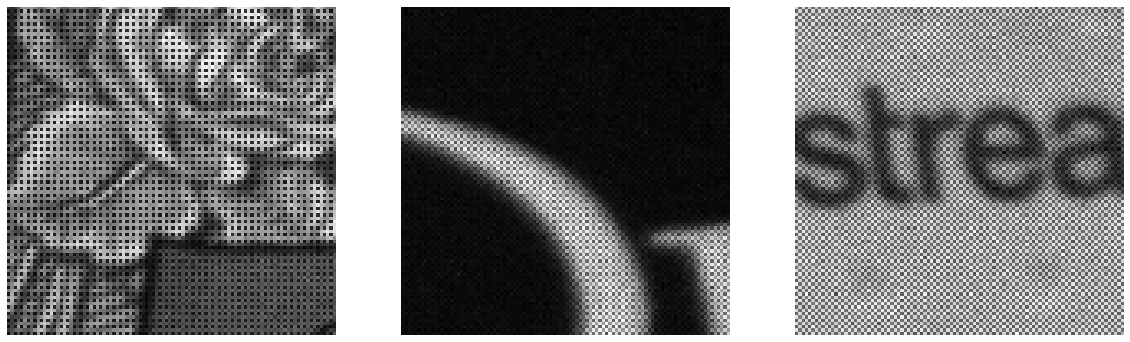

In [ ]:
plt.gray()
plt.rcParams['figure.figsize'] = [20, 10]
plt.subplot(1,3,1)
plt.imshow(rawImage[2600:2700,2600:2700])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(rawImage[1900:2000,500:600])
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(rawImage[750:850,1000:1100])
plt.axis('off')
plt.savefig('bayerPattern.pdf')
files.download('bayerPattern.pdf')

we can recover the rgb image by demosaicing. OpenCV implements bilinear interpolation to demosaic.

In [ ]:
colorI=cv2.cvtColor(rawImage, cv2.COLOR_BayerGR2BGR)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


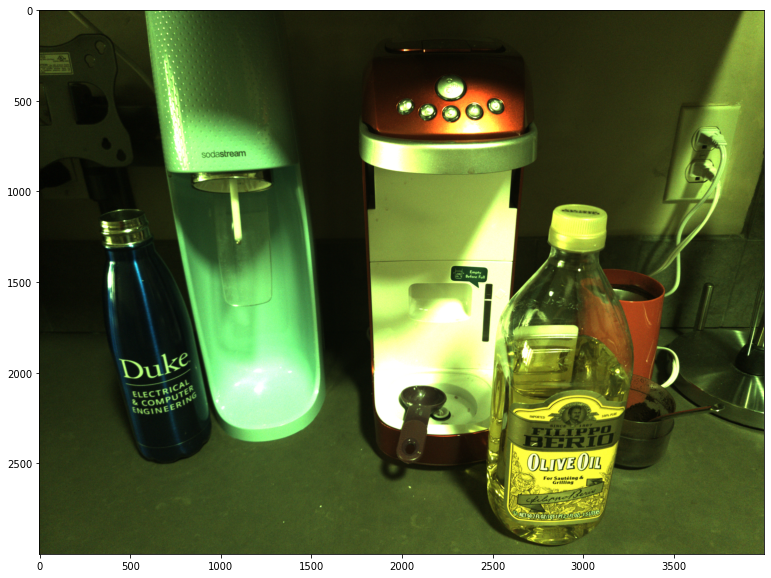

In [ ]:
plt.imshow(colorI)

# Demosaicing with neural processing

### Training data set 

We use the Kodak photo cd data set, which was digitized from film as raw so


1.   it consists of raw rgb images and 
2.   it was never sampled using a CFA

Not really prefect, but should be ok. There are 24 images, but we break them into sub images of size 64 by 64 to obtain a suitable set for training

The 24 image kodak data set is available as png images at https://www.kaggle.com/datasets/sherylmehta/kodak-dataset?select=kodim24.png


In [ ]:
im=np.zeros((24,2048,3072,3))
for pop in range(1,10):
  fileN="D65_TIFF_IMAGES/IMG000"+np.str(pop)+".tif"
  imm = Image.open(fileN)
  imm=np.array(imm)
  w,h,c =imm.shape
  if w>h:
    imm=imm.transpose(1,0,2)
  im[pop-1,:,:,:]=np.array(imm)/255.
for pop in range(10,25):
  fileN="D65_TIFF_IMAGES/IMG00"+np.str(pop)+".tif"
  imm = Image.open(fileN)
  imm=np.array(imm)
  w,h, c =imm.shape
  if w>h:
    imm=imm.transpose(1,0,2)
  im[pop-1,:,:,:]=np.array(imm)/255.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

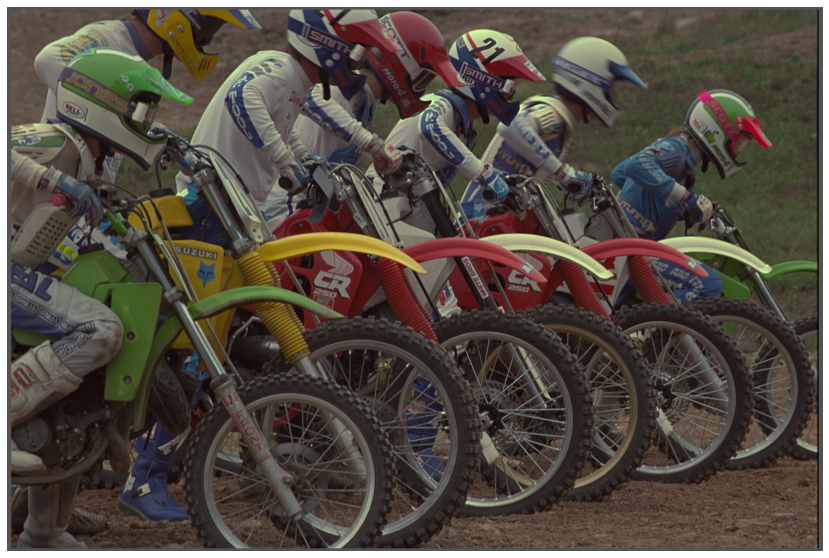

In [ ]:
plt.imshow(im[4,:,:,:])
plt.axis('off')
plt.savefig('motorbikes.pdf')
files.download('motorbikes.pdf')

### creation of training blocks

each image consists of 16 by 24=384 128 by 128 blocks. We use the first 20 images to generate 7680 training images and the last 4 images to generate 1536 test images

In [ ]:
trainS=7680
testS=1536
xtrain=np.zeros((trainS,64,64,4))
ytrain=np.zeros((trainS,128,128,3))
xtest=np.zeros((testS,64,64,4))
ytest=np.zeros((testS,128,128,3))
for imc in range(20):
  for row in range(16):
    for column in range(24):
      ytrain[(imc*20*16+row*24+column),:,:,:]=im[imc,(row*128):((row+1)*128),(column*128):((column+1)*128):,:]
      xtrain[(imc*20*16+row*24+column),:,:,:]=cfaSample.predict(im[imc:(imc+1),(row*128):((row+1)*128),(column*128):((column+1)*128):,:])
for imc in range(4):
  for row in range(16):
    for column in range(24):
      ytest[(imc*20*16+row*24+column),:,:,:]=im[imc+20,(row*128):((row+1)*128),(column*128):((column+1)*128):,:]
      xtest[(imc*20*16+row*24+column),:,:,:]=cfaSample.predict(im[(imc+20):(imc+21),(row*128):((row+1)*128),(column*128):((column+1)*128):,:])
xtrain=np.reshape(xtrain, (len(xtrain), 64, 64, 4))
ytrain=np.reshape(ytrain, (len(ytrain), 128, 128, 3))
xtest=np.reshape(xtest, (len(xtest), 64, 64, 4))
ytest=np.reshape(ytest, (len(ytest), 128, 128, 3))
train_dataset = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
test_dataset = tf.data.Dataset.from_tensor_slices((xtest,ytest))
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

### Color sampling functions

In [ ]:

#This is the filter array for Bayer color sampling
def bayerCFA(shape,dtype='none'):
    kernel = np.array([[[1,0,0],[0,0,0]],[[0,0,0],[0,0,0]]])
    kernel = np.stack((kernel,np.array([[[0,0,0],[0,1,0]],[[0,0,0],[0,0,0]]]),np.array([[[0,0,0],[0,0,0]],[[0,1,0],[0,0,0]]]),np.array([[[0,0,0],[0,0,0]],[[0,0,0],[0,0,1]]] )),axis=-1)
    return kernel

In [ ]:
# This network transforms a 32 by 32 color image into a 16 by 16 by 4 bayer sample array 
inputs = layers.Input(shape=(None,None,3))
cfa = layers.Conv2D(4, (2,2), (2,2), use_bias=False, input_shape=(32,32,3),kernel_initializer=bayerCFA)(inputs)
cfaSample=Model(inputs,cfa)


In [ ]:
dog=cfaSample.predict(im[4:5,:,:,:])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

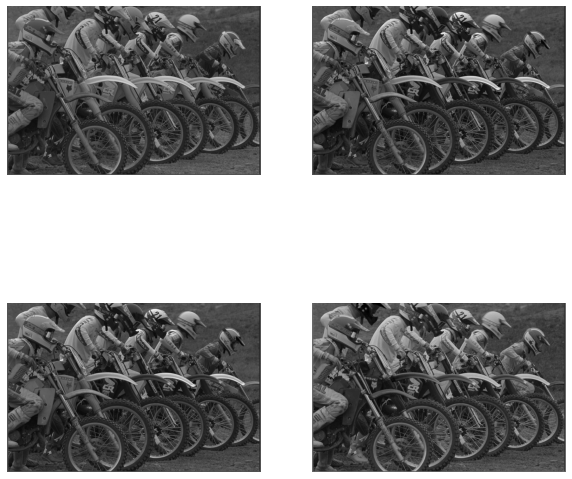

In [ ]:

plt.rcParams['figure.figsize'] = [10, 10]
plt.gray()
plt.subplot(2,2,1)
plt.imshow(dog[0,:,:,0])
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(dog[0,:,:,1])
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(dog[0,:,:,2])
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(dog[0,:,:,3])
plt.axis('off')
plt.savefig('motorbikeStack.pdf')
files.download('motorbikeStack.pdf')

## Network architecture

#### autoencoder with residuals

In [ ]:
inputs = layers.Input(shape=(None,None,4))
# Encoder
x1 = layers.Conv2D(16, (2, 2), strides=2, activation="relu", padding="same")(inputs)
x = layers.MaxPooling2D((2, 2))(x1)
x2 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x3 = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x2)
x = layers.MaxPooling2D((2, 2))(x3)
x = layers.Conv2D(128, (3, 3),  activation="relu", padding="same")(x)
# Decoder
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)

x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x=layers.add([x,x2])
x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(x)
x=layers.add([x,x1])
x = layers.Conv2DTranspose(4, (3, 3), strides=2, activation="relu", padding="same")(x)
x=layers.add([x,inputs])
x = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="linear", padding="same")(x)

# Autoencoder
demosaic = Model(inputs, x)
demosaic.compile(optimizer="adam", loss="mean_squared_error")
demosaic.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, None, None, 1 272         input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, None, None, 1 0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, None, None, 3 4640        max_pooling2d_4[0][0]            
____________________________________________________________________________________________

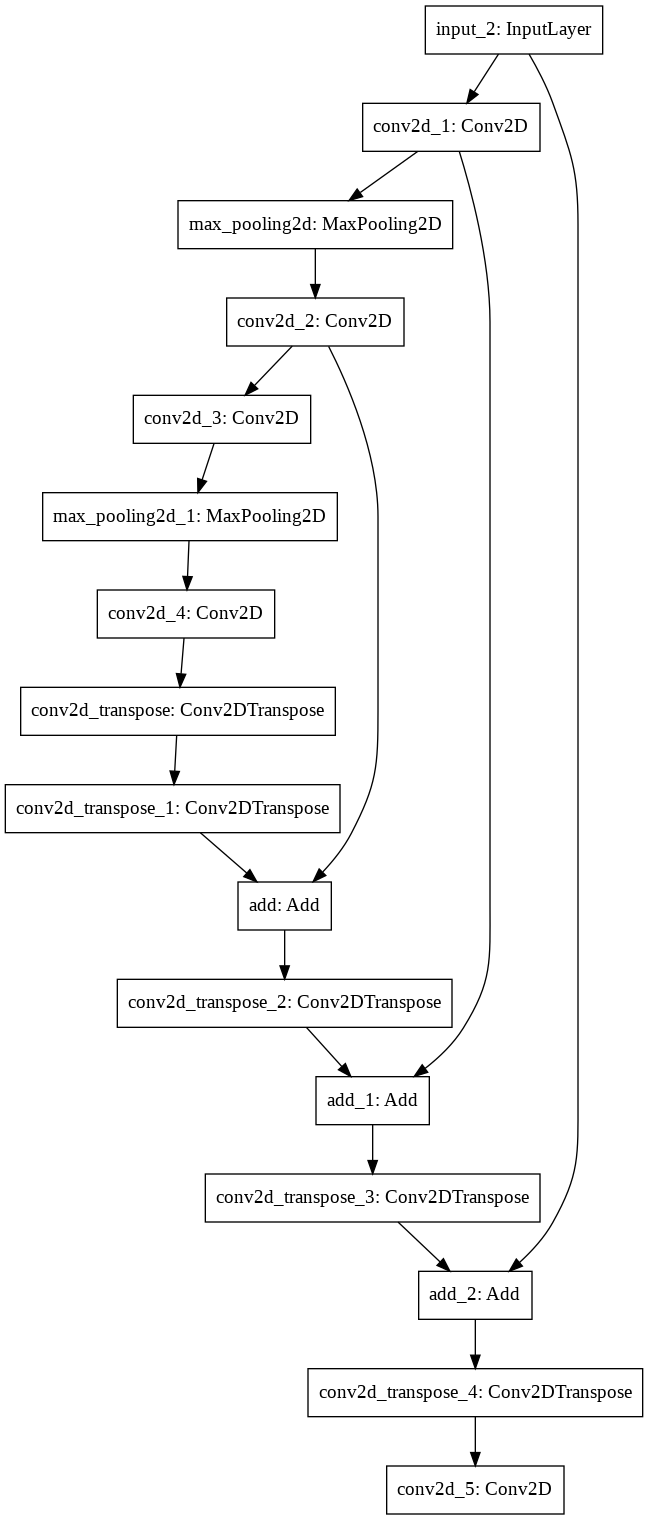

In [ ]:
keras.utils.plot_model(demosaic)

##### train the model

In [ ]:
demosaic.fit(train_dataset,
    epochs=20,
    batch_size=32,
    shuffle=True,
    validation_data=test_dataset
)

Epoch 1/20
240/240 [==============================] - 17s 67ms/step - loss: 0.0122 - val_loss: 0.0056
Epoch 2/20
240/240 [==============================] - 16s 68ms/step - loss: 0.0033 - val_loss: 0.0041
Epoch 3/20
240/240 [==============================] - 16s 68ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 4/20
240/240 [==============================] - 17s 69ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 5/20
240/240 [==============================] - 17s 69ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 6/20
240/240 [==============================] - 17s 69ms/step - loss: 9.3963e-04 - val_loss: 0.0019
Epoch 7/20
240/240 [==============================] - 17s 69ms/step - loss: 7.8056e-04 - val_loss: 0.0018
Epoch 8/20
240/240 [==============================] - 17s 69ms/step - loss: 6.6968e-04 - val_loss: 0.0012
Epoch 9/20
240/240 [==============================] - 16s 68ms/step - loss: 5.4579e-04 - val_loss: 8.5881e-04
Epoch 10/20
240/240 [==============================] - 17s 69m

In [ ]:
demosaic.save("demosaic")
!tar -czvf demosaic.tar.gz demosaic/
files.download('demosaic.tar.gz')

INFO:tensorflow:Assets written to: demosaic/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


demosaic/
demosaic/saved_model.pb
demosaic/keras_metadata.pb
demosaic/variables/
demosaic/variables/variables.index
demosaic/variables/variables.data-00000-of-00001
demosaic/assets/


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
dog=demosaic.predict(cfaSample.predict(im[4:5,:,:,:]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 3071.5, 2047.5, -0.5)

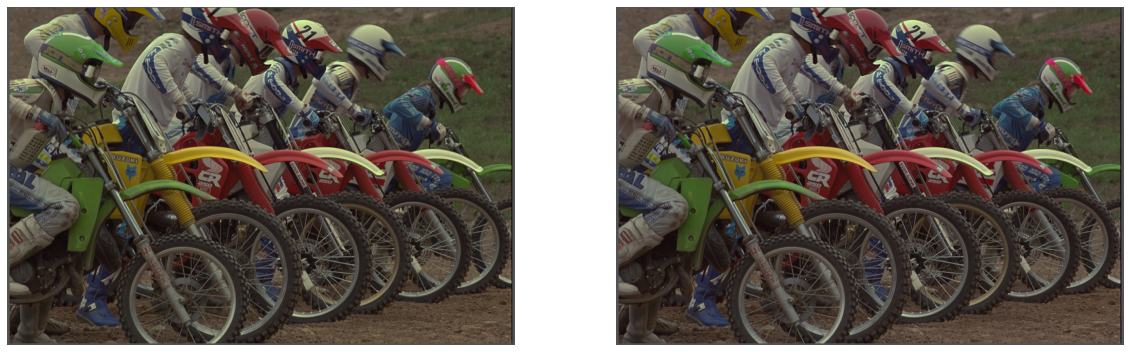

In [ ]:
plt.subplot(1,2,1)
plt.imshow(dog[0,:,:,:])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(im[4,:,:,:])
plt.axis('off')

## loading trained model

In [ ]:
!wget --no-check-certificate --content-disposition 'https://github.com/djbradyAtOpticalSciencesArizona/computationalImaging/raw/master/inverseProblems/demosaic.tar.gz'
!tar -xvf demosaic.tar.gz 

--2021-08-24 22:31:55--  https://github.com/djbradyAtOpticalSciencesArizona/computationalImaging/raw/master/inverseProblems/demosaic.tar.gz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/djbradyAtOpticalSciencesArizona/computationalImaging/master/inverseProblems/demosaic.tar.gz [following]
--2021-08-24 22:31:56--  https://raw.githubusercontent.com/djbradyAtOpticalSciencesArizona/computationalImaging/master/inverseProblems/demosaic.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3164670 (3.0M) [application/octet-stream]
Saving to: ‘demosaic.tar.gz’

demosaic.tar.gz     100%[==============

In [ ]:
demosaic = keras.models.load_model('demosaic')

In [ ]:
def rgb2bayerGR2(image):
  w,h, c=image.shape
  bayer=np.zeros((w,h))
  bayer[0:w:2,0:h:2]=image[0:w:2,0:h:2,1]
  bayer[1:w:2,1:h:2]=image[1:w:2,1:h:2,1]
  bayer[0:w:2,1:h:2]=image[0:w:2,1:h:2,0]
  bayer[1:w:2,0:h:2]=image[1:w:2,0:h:2,2]
  bayer=255*bayer/np.max(bayer)
  bayer=bayer.astype('uint8')
  return bayer
  

  



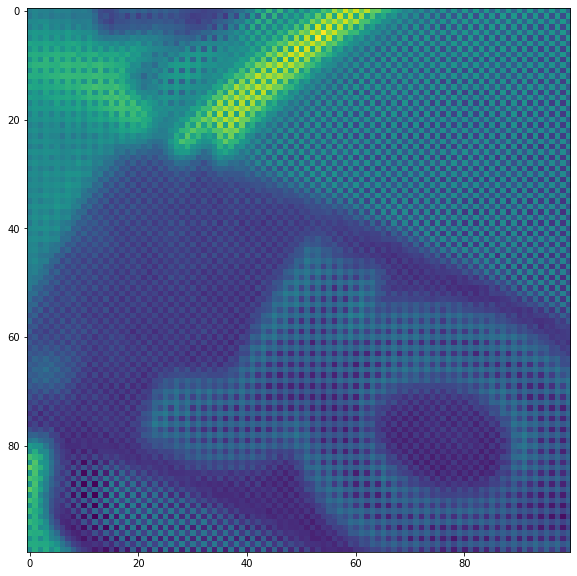

In [ ]:
plt.imshow(rgb2bayerGR2(im[4,:,:,:])[200:300,200:300])

In [ ]:
colorI=cv2.cvtColor(rgb2bayerGR2(im[4,:,:,:]), cv2.COLOR_BayerGR2BGR)

(-0.5, 3071.5, 2047.5, -0.5)

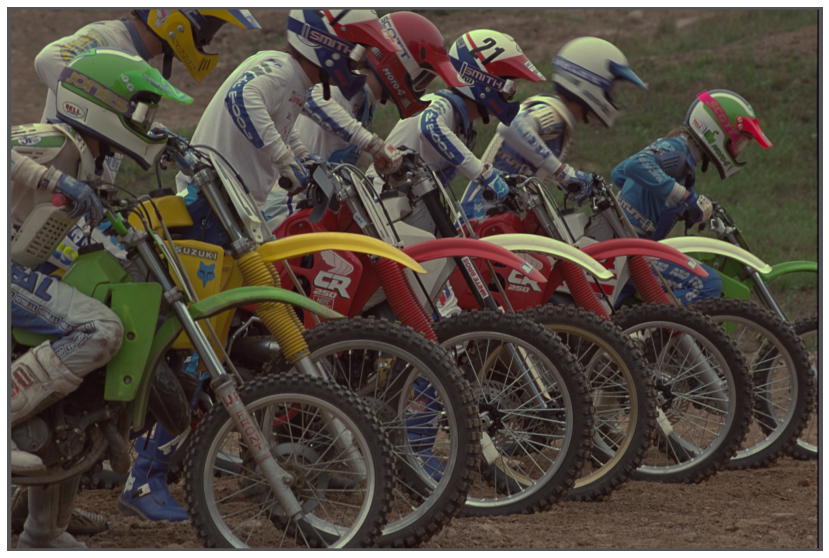

In [ ]:
plt.imshow(colorI)
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 3071.5, 2047.5, -0.5)

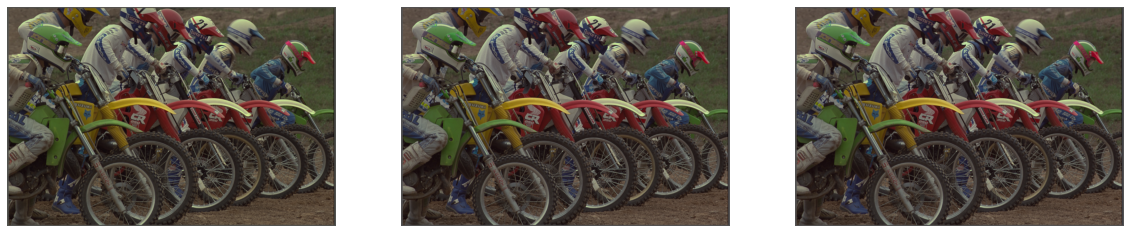

In [ ]:
plt.subplot(1,3,1)
plt.imshow(demosaic.predict(cfaSample.predict(im[4:5,:,:,:]))[0,:,:,:])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(im[4,:,:,:])
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(rgb2bayerGR2(im[4,:,:,:]), cv2.COLOR_BayerGR2BGR))
plt.axis('off')


(-0.5, 49.5, 49.5, -0.5)

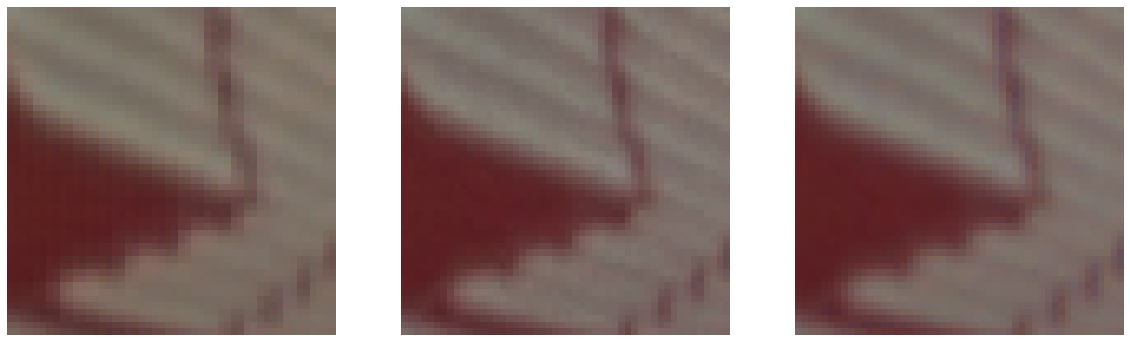

In [ ]:
plt.subplot(1,3,1)
plt.imshow(demosaic.predict(cfaSample.predict(im[4:5,:,:,:]))[0,950:1000,1200:1250,:])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(im[4,950:1000,1200:1250,:])
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(rgb2bayerGR2(im[4,:,:,:]), cv2.COLOR_BayerGR2BGR)[950:1000,1200:1250,:])
plt.axis('off')


(-0.5, 24.5, 24.5, -0.5)

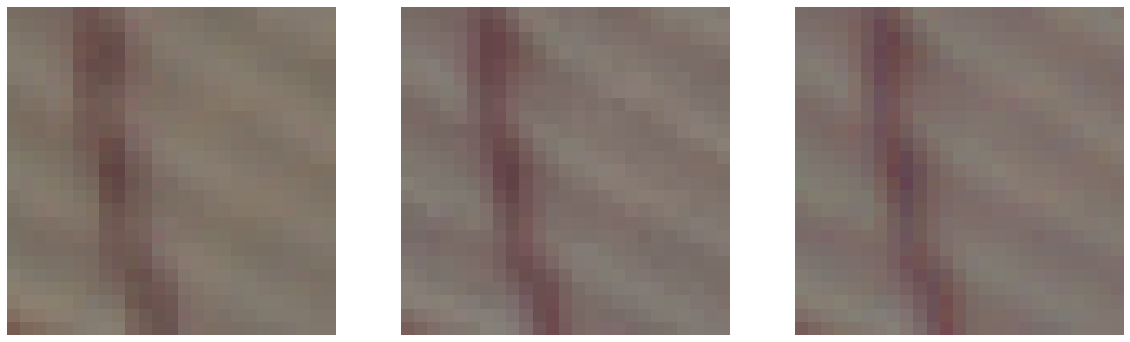

In [ ]:
plt.subplot(1,3,1)
plt.imshow(demosaic.predict(cfaSample.predict(im[4:5,:,:,:]))[0,950:975,1225:1250,:])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(im[4,950:975,1225:1250,:])
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(rgb2bayerGR2(im[4,:,:,:]), cv2.COLOR_BayerGR2BGR)[950:975,1225:1250,:])
plt.axis('off')


In [ ]:
def colorStack(image):
  w,h=image.shape
  cs=np.zeros((np.int(w/2),np.int(h/2),4))
  cs[:,:,0]=image[0:w:2,1:h:2]
  cs[:,:,1]=image[0:w:2,0:h:2]
  cs[:,:,2]=image[1:w:2,1:h:2]
  cs[:,:,3]=image[1:w:2,0:h:2]
  cs=cs/np.max(cs)
  cs=np.reshape(cs, (1, np.int(w/2), np.int(h/2), 4))
  return cs


In [ ]:
pop=demosaic.predict(colorStack(rawImage)[0:1024,0:1024])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


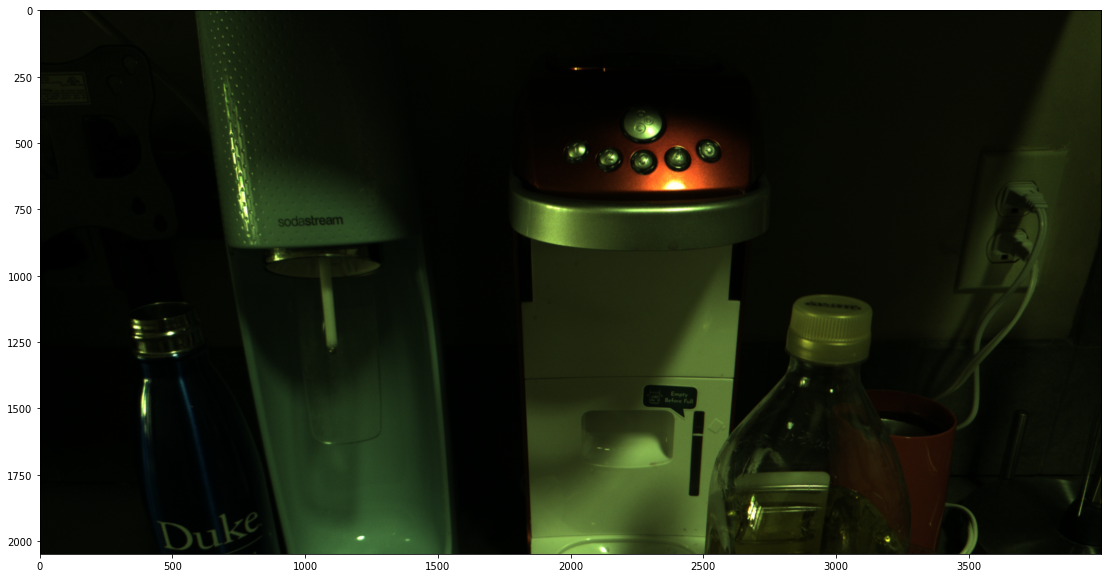

In [ ]:
plt.imshow(pop[0,:,:,:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 3071.5, 2047.5, -0.5)

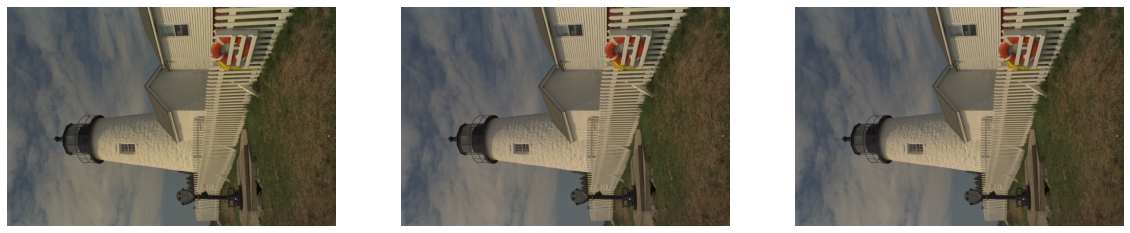

In [ ]:
plt.subplot(1,3,1)
plt.imshow(demosaic.predict(cfaSample.predict(im[18:19,:,:,:]))[0,:,:,:])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(im[18,:,:,:])
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(rgb2bayerGR2(im[18,:,:,:]), cv2.COLOR_BayerGR2BGR))
plt.axis('off')

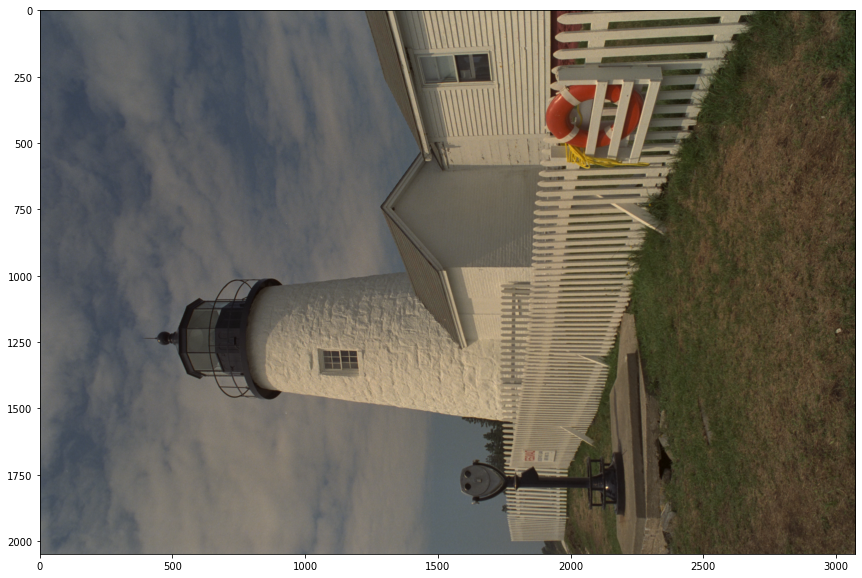

In [ ]:
plt.imshow(im[18,:,:,:])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

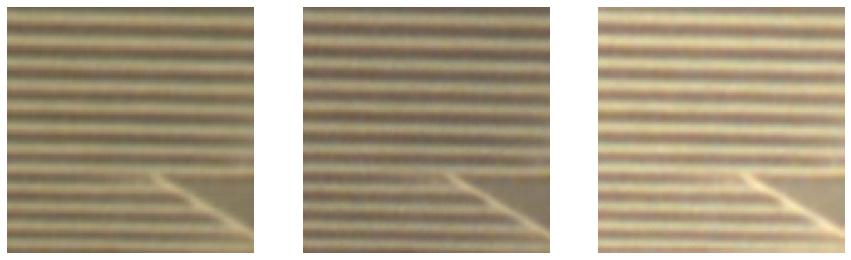

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.subplot(1,3,1)
plt.imshow(demosaic.predict(cfaSample.predict(im[18:19,:,:,:]))[0,1500:1600,1900:2000,:])
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(im[18,1500:1600,1900:2000,:])
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(rgb2bayerGR2(im[18,1500:1600,1900:2000,:]), cv2.COLOR_BayerGR2BGR))
plt.axis('off')
plt.savefig('fence.pdf')
files.download('fence.pdf')